In [12]:
from utils_tesis.signalload import CSV_pandas
import numpy as np
import matplotlib.pyplot as plt


In [13]:
signals = CSV_pandas()

C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_SEM/T01_high/L090.36_091.31.csv
Se seleccionó L090.36_091.31


In [14]:
signal, t, _ = signals.load_data('I: X0023A-R1A')

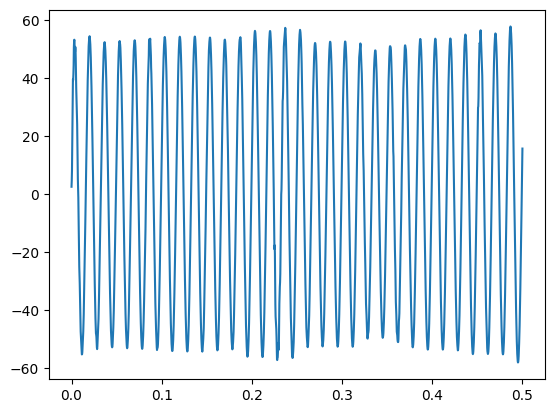

In [15]:
plt.plot(t, signal)